### Full POP model works

In [1]:
include("LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using DynamicPolynomials
using LinearAlgebra
using Dates
using HDF5

Consider simple Lindblad master equation with just one dissipator:

$m
     \frac{d\rho}{dt} = - \frac{i}{\hbar}[H, \rho]+\left[A \rho A^\dagger - \frac{1}{2}\left\{ A^\dagger A, \rho \right\} \right]
$

The Lindblad equation invariant under homogenous transformations

1. $H \rightarrow H' = H + \frac{1}{2i} \sum_j \gamma_j (a_j^* A_j - a_j A_j^\dagger) + bI$ 

  it means that manipulating $bI$ we can always choose the zero enegy level of Hamiltonian and look for it     in the form:

$
    H = \begin{pmatrix} e_1 & h_1 - i h_2 \\ h_1 + i h_2 & 0
   \end{pmatrix}
$
    
    
2. $A \rightarrow A' + aI$ - it means we can pick traceless $A$ without loss of generality.

$
A = \begin{pmatrix} a_1 + i b_1 &   a_2 + i b_2\\  a_3 + i b_3 & -a_1 - i b_1
   \end{pmatrix} $
   
$\operatorname{Tr} A = 0$

3. The Lindblad equation is also invariant under any unitary transformation $v$ of Lindblad operators and constants:

$\sqrt{\gamma_i}A_i \rightarrow \sqrt{\gamma'_i}A'_i = \sum_j v_{ij} \sqrt{\gamma} A_j$

if we have just one operator $A$ it means that we can pick any of its unitary invariants.

   
So the $A$ operator is both traceless and phase invariant
$
A = \begin{pmatrix} a e^{i \phi_a} & b e^{i \phi_b} \\ c e^{i \phi_c} & -a e^{i \phi_a}
   \end{pmatrix} 
= \begin{pmatrix} a e^{i (\phi_a - \phi_b)} & b \\ c e^{i (\phi_c - \phi_b)} & -a e^{i (\phi_a - \phi_b)}
   \end{pmatrix} e^{i \phi_b}
$

Therefore we can possibly look for jump operator of the form:

$
A = \begin{pmatrix} a_{11} + i b_{11} & a_{12} \\ a_{21} + i b_{21} & -a_{11} - i b_{11} 
   \end{pmatrix} 
$

In [2]:
#using DynamicPolynomials

@polyvar g

@polyvar e[1]
@polyvar h[1:2]

#Hˢʸᵐᵇ = [ 0.      0.
#         0.     e[1] ]

# Hˢʸᵐᵇₐₙ
Hˢʸᵐᵇ = [ e[1]               h[1] - im*h[2]
          h[1] + im*h[2]     0.             ]

2×2 Matrix{Polynomial{true, ComplexF64}}:
 e₁                  h₁ + (0.0-1.0im)h₂
 h₁ + (0.0+1.0im)h₂  0.0+0.0im

In [3]:
@polyvar a[1:4]
@polyvar b[1:4]

#Aˢʸᵐᵇ = [  0.              a[2] + im*b[2]
#           a[3] + im*b[3]           0.             ]

Aˢʸᵐᵇ = [ a[1] + im*b[1]     a[2] + im*b[2]
          0                 -a[1] - im*b[1]   ]

2×2 Matrix{Polynomial{true, Complex{Int64}}}:
 a₁ + (0+1im)b₁  a₂ + (0+1im)b₂
 0+0im           -a₁ + (0-1im)b₁

In [4]:
pwd()

"/home/zah/POP23"

In [5]:
parentdir = pwd()
data_dir = parentdir*"/DATA/"
println(data_dir)

output_directory = parentdir*"/MODELS/"

/home/zah/POP23/DATA/


"/home/zah/POP23/MODELS/"

### Train models loop

In [6]:
γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

γᵢ = "0.079477"

ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵢ)
ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵢ)
ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵢ)
ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵢ)

objₑₓ = 0
#objₑₓₐₙ = 0

print(length(tʸ))
    
beg_train = 1
end_train = 1000

@time for (ρ,t) in zip([ρᵍ, ρᵉ, ρˣ, ρʸ], [tᵍ, tᵉ, tˣ, tʸ]) #zip([ρᵍ, ρˣ], [tᵍ, tˣ])  

    t = convert(Vector{Float64}, t)[beg_train:end_train]
    @assert maximum(diff(t)) ≈ minimum(diff(t)) ≈ t[2]-t[1]

    # Convert cut ρ series:
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)[beg_train:end_train]
    objₑₓ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ])
    #objₑₓₐₙ += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇₐₙ, [Aˢʸᵐᵇ])

end # of files (initial states) loop

1256  6.222449 seconds (40.70 M allocations: 4.751 GiB, 12.73% gc time, 57.41% compilation time)


In [7]:
test_files = ["State_D"*string(n) for n=1:20];

obj20 = 0

for df in test_files # loop over initial states

    print(df*" ")

    ρ, t = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", γᵢ)
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)[beg_train:end_train]
    obj20 += LiPoSID.simpson_obj(ρ, t,  Hˢʸᵐᵇ, [Aˢʸᵐᵇ])

end

objₑₓ += obj20;

State_D1 State_D2 State_D3 State_D4 State_D5 State_D6 State_D7 State_D8 State_D9 State_D10 State_D11 State_D12 State_D13 State_D14 State_D15 State_D16 State_D17 State_D18 State_D19 State_D20 

In [8]:
solₑₓⁿᵉʷ, best_methodₑₓⁿᵉʷ = LiPoSID.sos_min_newton(objₑₓ) 

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 0.00893840773662762

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 0.00893839255424536
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
val_p = [0.008938404102991626, 0.00

(PolyVar{true}[e₁, h₁, h₂, a₁, a₂, b₁, b₂] => [25.12608995205875, 4.330389916321281e-6, 1.2495965207059682e-5, 4.246126350102824e-6, 0.19939136725284023, 2.8105828039388517e-5, 0.1992102987404109], "scaled_tssos")

In [9]:
best_methodₑₓⁿᵉʷ

"scaled_tssos"

In [10]:
Hˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, solₑₓⁿᵉʷ)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (25.1261+0.0im)           (4.33039e-6-1.2496e-5im)
 (4.33039e-6+1.2496e-5im)  0.0+0.0im

In [11]:
Aˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, solₑₓⁿᵉʷ)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (4.24613e-6+2.81058e-5im)  (0.199391+0.19921im)
 0.0+0.0im                  (-4.24613e-6-2.81058e-5im)

In [12]:
eigen(convert.(ComplexF64, Aˢⁱᵈₑₓ))

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 -4.246126350102824e-6 - 2.8105828039388517e-5im
  4.246126350102824e-6 + 2.8105828039388517e-5im
vectors:
2×2 Matrix{ComplexF64}:
          1.0+0.0im          1.0+0.0im
 -0.000162273-0.000119791im  0.0+0.0im

In [13]:
#gˢⁱᵈₑₓ = subs(g, solₑₓⁿᵉʷ)

In [14]:
norm(Aˢⁱᵈₑₓ[1,2])^2

0.07944166045920076

In [15]:
real(tr(Aˢʸᵐᵇ'*Aˢʸᵐᵇ))^2

4a₁⁴ + 4a₁²a₂² + 8a₁²b₁² + 4a₁²b₂² + a₂⁴ + 4a₂²b₁² + 2a₂²b₂² + 4b₁⁴ + 4b₁²b₂² + b₂⁴

In [16]:
#α = .1 #regularization coefficient
α = 0

robjₑₓ = objₑₓ + α * real(tr(Aˢʸᵐᵇ'*Aˢʸᵐᵇ))^2

#robjₑₓ = objₑₓ + α * (sum(a.^4)+sum(b.^4)+sum(h.^2)) #adding regularization

rsolₑₓⁿᵉʷ, best_methodₑₓⁿᵉʷ = LiPoSID.sos_min_newton(robjₑₓ) 

rHˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, rsolₑₓⁿᵉʷ)
rAˢⁱᵈₑₓ = subs(Aˢʸᵐᵇ, rsolₑₓⁿᵉʷ)

best_methodₑₓⁿᵉʷ

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 0.00893840773662762
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
optimum = 0.00893839255424536
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
val_p = [0.008938404102991626, 0.008938404102536879]


"scaled_tssos"

In [17]:
rHˢⁱᵈₑₓ = subs(Hˢʸᵐᵇ, rsolₑₓⁿᵉʷ)

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (25.1261+0.0im)           (4.33039e-6-1.2496e-5im)
 (4.33039e-6+1.2496e-5im)  0.0+0.0im

In [18]:
rAˢⁱᵈₑₓ

2×2 Matrix{Polynomial{true, ComplexF64}}:
 (4.24613e-6+2.81058e-5im)  (0.199391+0.19921im)
 0.0+0.0im                  (-4.24613e-6-2.81058e-5im)

In [19]:
norm(rAˢⁱᵈₑₓ[2,1])^2

0.0

In [20]:
norm(rAˢⁱᵈₑₓ[1,2])^2

0.07944166045920076

In [21]:
"0.079477"

"0.079477"

In [22]:
#H = DenseOperator(basis, Hˢⁱᵈₑₓ)
#A = DenseOperator(basis, Aˢⁱᵈₑₓ)

H = DenseOperator(basis, rHˢⁱᵈₑₓ)
A = DenseOperator(basis, rAˢⁱᵈₑₓ)


FF =[]

train_files = ["State_B"*string(n) for n=1:4]
test_files = ["State_D"*string(n) for n=1:20]
all_files = [test_files... train_files...]
            
for df in all_files # loop over initial states

    print(df*" ")

    start_time = time()

    ρ, t = LiPoSID.get_rho_series(data_dir*df*"_2CUT_data.h5", γᵢ)
    ρ = convert(Vector{Matrix{ComplexF64}}, ρ)

    ρᵗᵉˢᵗ = [DenseOperator(basis,Hermitian(ρₜ)) for ρₜ in ρ]

    t = convert(Vector{Float64}, t)

    tᴸᴹᴱ, ρᴸᴹᴱ  = timeevolution.master(t, ρᵗᵉˢᵗ[1], H, [A])

    F = [abs(fidelity(ρ₁, ρ₂)) for (ρ₁, ρ₂) in zip(ρᵗᵉˢᵗ, ρᴸᴹᴱ)]

    println(minimum(F))
    
    push!(FF,F)

end
            
#0.9848

State_D1 0.9993653743803588
State_D2 0.9993685809199616
State_D3 0.9993684990132192
State_D4 0.9993700920857247
State_D5 0.999182100565433
State_D6 0.9991820628171786
State_D7 0.9990473064716026
State_D8 0.9990484988563111
State_D9 0.9998452412087733
State_D10 0.9998783986879993
State_D11 0.9993684588328026
State_D12 0.9993701173730273
State_D13 0.9993653033799038
State_D14 0.9993685808104984
State_D15 0.9991826475536201
State_D16 0.9991826409090887
State_D17 0.9990472549360532
State_D18 0.9990484702423876
State_D19 0.9998783979619086
State_D20 0.9998452265054407
State_B1 0.9999482665628981
State_B2 0.9999978526491271
State_B3 0.9990463032516169
State_B4 0.9990632608095192


In [23]:
using StatsPlots

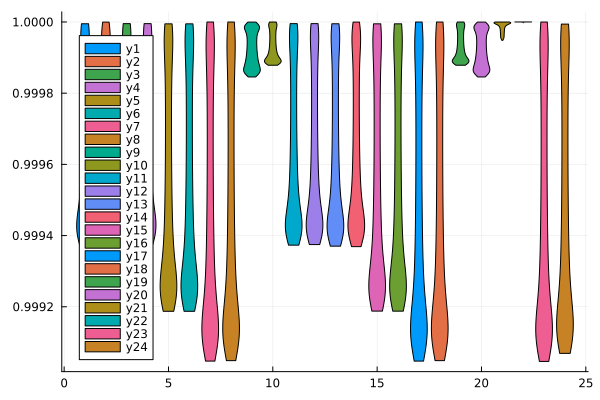

In [24]:
violin(FF)